### 实验总体情况：

利用NLP相关流程对邮件文本进行分词，清洗，标准化，特征提取等操作，最后进行建模并进行评估。

利用了nltk Natural Language Toolkit

estimator
选择sklean的LogisticRegression

对模型分别进行简单交叉验证和5折交叉验证


In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


加载数据集
我所使用的数据集来自UHT，该数据集有2列，5728行。

In [50]:
df = pd.read_csv('/kaggle/input/spam-filter/emails.csv')

来简单看一下数据集的情况

In [51]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [52]:
df.shape

(5728, 2)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


数据集中没有缺失的数据


In [54]:
df.isna().sum()

text    0
spam    0
dtype: int64

我们可以发现，本数据集中垃圾邮件有1368个，标记为'1'，非垃圾邮件有4360个，标记为'0'

In [55]:
df['spam'].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

图形化查看数据集

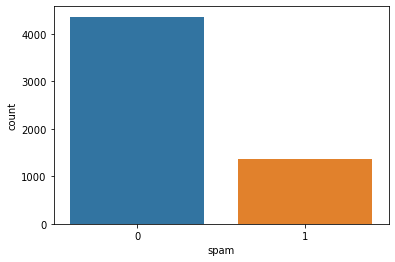

In [56]:
sns.countplot(df['spam'])

### 接下来，我们进行**NLP**的基本流程，利用便利的nltk包

In [57]:
from nltk import word_tokenize

函数 ***count_words*** 的作用是将每一条email的内容分成以字词为单位的数据结构

In [58]:
def count_words(text):
    words = word_tokenize(text)
    return len(words)

将***count_words*** 应用到 ***df['text']*** 上，并将每个邮件单词个数的结果存储到 ***df['count']*** 中

In [59]:
df['count']=df['text'].apply(count_words)

In [60]:
df['count']

0       325
1        90
2        88
3        99
4        53
       ... 
5723    298
5724    245
5725    516
5726    277
5727    445
Name: count, Length: 5728, dtype: int64

In [61]:
df.groupby('spam')['count'].mean()

spam
0    346.835321
1    267.896199
Name: count, dtype: float64

对数据集进行 ***shuffle*** 操作，提升模型质量，提升预测表现

In [62]:
# df
from sklearn.utils import shuffle
df = shuffle(df)
df

,text,spam,count
1023,Subject: i missed you 24632 if amateurs is wh...,1,370
1420,Subject: ees retail risk meeting 1 / 31 this ...,0,408
292,"Subject: re : new page hi sweetie , come see...",1,137
4832,Subject: re : your visit to carnegie mellon k...,0,176
5308,Subject: enterprise wide risk management meeti...,0,99
...,...,...,...
939,Subject: free hgh - look 10 years younger in 3...,1,142
5461,Subject: re : agenda for houston visit hi mik...,0,289
2378,Subject: california power 1 / 15 / 01 vince -...,0,1093
271,Subject: re : your financial security ! high p...,1,252


### 下面进行文本的处理，包括：
- 除去标点符号Remove Punctuation，
- 连接词Stop Words，
- 词干提取(stemming)和词型还原(lemmatization)

In [63]:
import string
from nltk.corpus import stopwords

除去连接词和停用词

In [64]:
def process_text(text):
    no_punc = [char for char in text if char not in string.punctuation]
    no_punc = ''.join(no_punc)
    
    
    return ' '.join([word for word in no_punc.split() if word.lower() not in stopwords.words('english')])

停用词就是句子没什么必要的单词，去掉他们以后对理解整个句子的语义没有影响。文本中会存在大量的虚词、代词或者没有特定含义的动词、名词，这些词语对文本分析起不到任何的帮助，我们往往希望能去掉这些“停用词”。在英文中，例如，"a"，"the",“to"，“their”等冠词，借此，代词..... 我们可以直接用nltk中提供的英文停用词表 ***stopwords.words('english')***

In [65]:
df['text']=df['text'].apply(process_text)

In [66]:
df['text']

1023    Subject missed 24632 amateurs want take look h...
1420    Subject ees retail risk meeting 1 31 confirm m...
292     Subject new page hi sweetie come see beautiful...
4832    Subject visit carnegie mellon kent thanks lot ...
5308    Subject enterprise wide risk management meetin...
                              ...                        
939     Subject free hgh look 10 years younger 3 weeks...
5461    Subject agenda houston visit hi mike thanks me...
2378    Subject california power 1 15 01 vince kristin...
271     Subject financial security high priority econo...
4693    Subject hello hi vince thank offer bring jacob...
Name: text, Length: 5728, dtype: object

In [67]:
df['text'].iloc[0]

'Subject missed 24632 amateurs want take look hardcore sites young hottt teens best best comes amateurs believe take look amateur petite natural tight coeds petite natural breasted amateurs exclusive amateur xxx videos hundreds exclusive petite amateur models click check action http tour 2 amateurpetite com 1087 http tour 2 amateurpetite com 1087 ample amateurs breasts women men love men women old adage bigger better holds true find plenty hold stable stacked exclusive ample amateurs make mouth water hands tired looking http tour 2 ampleamateurs com 1087 http tour 2 ampleamateurs com 1087 amateur smut smuttiest xxx amateurs web real amateurs explicit photo shoots 1 000 high quality smut pics pics horny girl next door nasty amateurs gone wild http tourl amateursmut com 1087 http tourl amateursmut com 1087 taken mailing list simply hit reply button put remove anywhere subject'

#### eg: stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate”

In [68]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [69]:
def stemming (text):
    return ''.join([stemmer.stem(word) for word in text])

找到词的原始形式

In [70]:
df['text']=df['text'].apply(stemming)

In [71]:
df.head()

,text,spam,count
1023,Subject missed 24632 amateurs want take look h...,1,370
1420,Subject ees retail risk meeting 1 31 confirm m...,0,408
292,Subject new page hi sweetie come see beautiful...,1,137
4832,Subject visit carnegie mellon kent thanks lot ...,0,176
5308,Subject enterprise wide risk management meetin...,0,99


### It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text

对于每一个训练文本，考虑每种词汇在该训练文本中出现的频率。

CountVectorizer会将文本中的词语转换为词频矩阵，它通过fit_transform函数计算各个词语出现的次数。

In [72]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer= CountVectorizer()
message_bow = vectorizer.fit_transform(df['text'])

In [73]:
a = message_bow.toarray()
print(a[0])

[0 1 0 ... 0 0 0]


### 简单交叉验证 **划分训练集和验证集**8:2

In [74]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(message_bow,df['spam'],test_size=0.20)

### 建立模型并评估

In [75]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=0)
LR.fit(X_train,y_train)
# nb= MultinomialNB()
# nb.fit(X_train,y_train)
# y_pred = nb.predict(X_test)
y_pred = LR.predict(X_test)


In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       874
           1       0.98      0.98      0.98       272

    accuracy                           0.99      1146
   macro avg       0.99      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146



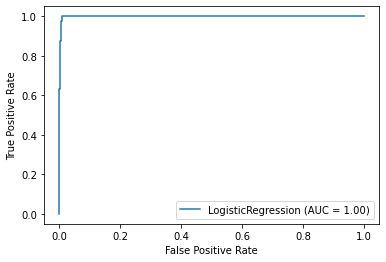

In [77]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(LR,X_test,y_test)

### 从ROC曲线图和模糊矩阵的结果可以看出，本模型的效果非常好

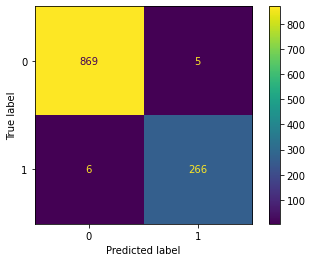

In [78]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(LR,X_test,y_test)

### 下面用5折交叉验证测试一下

In [79]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=5,shuffle=True)
print("Accuracy using Cross Validation is :",np.mean(cross_val_score(LR,message_bow,df['spam'],cv=kfold,scoring="accuracy"))*100," %")

Accuracy using Cross Validation is : 98.90015775394957  %


### 准确率达到了98.9%